<a href="https://colab.research.google.com/github/claredavies/ImageIndexing/blob/main/Image_Indexing_Assignment2_Clare_Davies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

**Before you turn this problem in, please put your full names and DNIs (or NIEs) below, and execute the cell:**

In [ ]:
NAME  = "Clare Davies"
DNI   = "PL5527043"

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd drive/MyDrive/ImageIndexing/iric_dev_kit

/content/drive/MyDrive/ImageIndexing/iric_dev_kit


Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. **Justify** all of your answers, **graphically** wherever possible. Remember that this notebook will be considered as a report to the work done during the assignment.

---

In [ ]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import scipy.cluster.vq as vq
import tqdm
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")
    
import iric_utils.eval_holidays as ev
import iric_utils.read_descriptors as rd

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
def plot_chart(values, labels, title, xlabel, ylabel):
  fig, ax = plt.subplots()
  ax.bar(labels, values)

  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  plt.show()

## Introduction
In this assignment, you will implement and evaluate different methods for indexing images. As usual during this course, we will use the [INRIA Holidays](http://lear.inrialpes.fr/people/jegou/data.php) dataset. **Check the Assignment 1 to further information about this dataset.**

We also need the provided script to evaluate a CBIR system on this dataset. Remember that the performance is measured computing the **mean average precision** (mAP) over all queries. **Check also the Assignment 1 to remember how to use this script and the different functions it offers.**

### Loading images
As we did in Assignment 1, for managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV2
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV2

In this assignment, we will use the original holidays dataset:

In [8]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []

with open('../holidays/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread('../holidays/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_names))
print(len(train_names))

500
991


## Loading SIFT descriptors
In this assignment we will create four additional lists:
- **`query_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *query* images
- **`query_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *query* images
- **`train_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *train* (database) images
- **`train_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *train* images

Unlike in Assigment 1, now you will be provided with a set of SIFT descriptors for each image, and, therefore, you do not need to create these lists from scratch. First, download the descriptors from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/Eam8Ld8YDaJAhNr91YVdAZIB_wVZJ8kzzKD7BR6R3LziMw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

Now, a new directory called `siftgeo` should be in your workspace, containing the set of SIFT descriptors for each image of the dataset. These descriptors are stored in binary format and, thus, you are also provided with some tools to load them. To be more precise, you can call the function `load_SIFT_descriptors` to load the descriptors of a list of images:

In [9]:
# Loading descriptors
query_kps, query_desc = rd.load_SIFT_descriptors(query_names, max_desc=1000)
train_kps, train_desc = rd.load_SIFT_descriptors(train_names, max_desc=1000)

# Some prints
print(len(query_kps))
print(len(train_kps))
print(len(query_desc))
print(len(train_desc))
print(query_desc[0].shape)
print(query_desc[0])

500
991
500
991
(1000, 128)
[[10.  6. 52. ... 15.  4.  0.]
 [16. 50. 12. ... 15.  4.  0.]
 [10. 11. 58. ...  7.  4.  4.]
 ...
 [27. 15.  0. ... 16.  8. 12.]
 [51. 47. 14. ... 35. 26.  0.]
 [ 2. 37. 25. ... 47. 13.  8.]]


For development purposes, we use the parameter `max_desc` to load a maximum number (1000) of the descriptors. This will speed up the execution of the rest of the notebook, while the decrease in performance will be minimum.

> **Some images do not have keypoints/descriptors. Take this into account when you develop your solution.**

## $k$-d trees and LSH 
Let's start coding. At this section, you will develop a retrieval system using $k$-d trees and Locality Sensitive Hashing (LSH). 

### General framework
As we did in the first assignment, you first will develop some utilities to simplify your work. Write a function called `search_image` to search an image in a generic index (database). You should search each descriptor of the given query image and obtain its two closest SIFT descriptors in the database. Next, the initial set of matches should be filtered using the **NNDR criterion (use 0.8 as ratio)**, as you did in the previous assignment. For each database image, its final score with regard to this query image will be the **number of correct matches** with this image:

In [ ]:
def search_image(descs, index, id_to_name):
    """
    Search an image in the index
    
    - descs: A numpy array. This is the set descriptors extracted from the query image
    - index: OpenCV FLANN index to search for descriptors.
    - id_to_name: An associative list to link every image index to its real name
        e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    """
  # Perform FLANN-based matching to find similar descriptors
    matches = index.knnMatch(descs, k=2)

    # Apply ratio test to filter out bad matches and find the best match for each query descriptor
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_matches.append(m)

    scores = {}
    for i, matchFound in enumerate(good_matches):
        img_idx = matchFound.imgIdx
        if img_idx not in scores:
            scores[img_idx] = 0
        scores[img_idx] += 1
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    similar_names = []
    for image_id, score in sorted_scores:
        similar_names.append(id_to_name[image_id])

    return sorted(similar_names)

Now, write a function called `compute_mAP`. Given a list of query images and a trained index, this function should return a Python dictionary with the ordered results for each query along with the computed mAP:

In [ ]:
def compute_mAP(query_names, query_desc, index, id_to_name, gt_file):
    """
    Perform a search for a list of query images against the database.
    
    - query_names: An ordered list with the names of the query images
    - query_desc: A list containing numpy arrays of size (ndesc_for_this_image, 128)
                  Each numpy array i corresponds to the descriptors found at image i
    - index: FLANN index
    - id_to_name: An associative array to link every image index to its real name
                  e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, an sorted list of the database images
    - m_ap: Mean Average Precision averaged over all queries
    """
    total_results = {}
    m_ap = 0.0
    
    i = 1
    for qname, qdesc in zip(query_names, query_desc):
        # Search for similar images
        results = search_image(qdesc, index, id_to_name)
        total_results[qname] = results
        i = i + 1
    
    m_ap = ev.compute_mAP(total_results, gt_file)
    return total_results, m_ap

### $k$-d Trees
In this section you will use a set of randomized $k$-d trees to index the database of images. Write a function called `build_db_kdtrees` to build a set of randomized $k$-d trees given a set of descriptors:

> **Useful links**: [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.5/dc/de2/classcv_1_1FlannBasedMatcher.html), [Possible algorithms to create an index](https://docs.opencv.org/4.5.5/db/d18/classcv_1_1flann_1_1GenericIndex.html#a8fff14185f9f3d2f2311b528f65b146c), [Algorithms IDs](https://github.com/opencv/opencv/blob/master/modules/flann/include/opencv2/flann/defines.h#L70)

In [ ]:
def build_db_kdtrees(descs, ntrees = 4):
    """
    Build a set of randomized k-d trees.
    
    - descs: A list of length len(img_names) where each element is a numpy array 
        of size (ndesc_for_this_image, 128). Each numpy array i corresponds 
        to the descriptors found on image i
    - ntrees: Number of trees to train
  
    RETURN: 
    - index: Trained FLANN index
    """  
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = ntrees)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    flann.add(descs)
    flann.train()
    return flann

In [ ]:
# Simple example of DB construction
index = build_db_kdtrees(train_desc[0:2])
print(len(index.getTrainDescriptors()))

2


In [ ]:
# Search an image in the index
img_res = search_image(query_desc[0], index, train_names[0:2])
print(img_res)

['100001.jpg', '100002.jpg']


In [ ]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_desc, index, train_names[0:2], '../holidays/holidays_images.dat')
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be 0 now, since there is only two images in the database.

['100001.jpg', '100002.jpg']
['100001.jpg', '100002.jpg']
0.002


**Q1**: Using functions developed so far, in the following cell compute the resulting **mAP** of the system **using 4 trees**:

In [ ]:
# Fill this variable with the resulting mAP
mAP_kdtree = 0.0

index = build_db_kdtrees(train_desc, ntrees = 4)
results, mAP_kdtree = compute_mAP(query_names, query_desc, index, train_names,'../holidays/holidays_images.dat')

In [ ]:
print('mAP: %.5f' % mAP_kdtree)

mAP: 0.27641


**Q2**: Are the results stable? Do you obtain always the same mAP? Why?

In [ ]:
index = build_db_kdtrees(train_desc, ntrees = 4)
_, mAP_kdtree_attempt1 = compute_mAP(query_names, query_desc, index, train_names,'../holidays/holidays_images.dat')
_, mAP_kdtree_attempt2 = compute_mAP(query_names, query_desc, index, train_names,'../holidays/holidays_images.dat')
_, mAP_kdtree_attempt3 = compute_mAP(query_names, query_desc, index, train_names,'../holidays/holidays_images.dat')

As seen below the results are stable as across different attempts the mAP remains the same. The algorithms generate consistent and stable results across multiple runs because the nearest neighbors found for a particular query point will be the same each time the algorithm is run. 

different mAPs for the same query:  0.27171375096630657 0.27171375096630657 0.27171375096630657


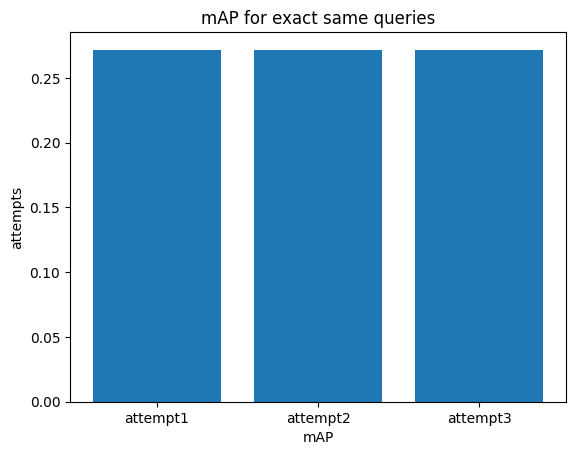

In [ ]:
print("different mAPs for the same query: ", mAP_kdtree_attempt1, mAP_kdtree_attempt2, mAP_kdtree_attempt3)
values = [mAP_kdtree_attempt1, mAP_kdtree_attempt2, mAP_kdtree_attempt3]
labels = ["attempt1", "attempt2", "attempt3"]
plot_chart(values, labels, "mAP for exact same queries", "mAP", "attempts")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q3:** Analyze the effect of changing the number of trees in terms of mAP and average response time. Some plots here can be useful to justify your answer.

As seen in the charts below increasing the number of trees causes a slight increase in mAP. This is also seen for the average response time which also increases with a higher number of trees.

In [ ]:
import time
start_time = time.time()
index_2_trees = build_db_kdtrees(train_desc, ntrees = 2)
train_time_2_trees = time.time() - start_time

start_time = time.time()
index_4_trees = build_db_kdtrees(train_desc, ntrees = 4)
train_time_4_trees = time.time() - start_time

start_time = time.time()
index_8_trees = build_db_kdtrees(train_desc, ntrees = 8)
train_time_8_trees = time.time() - start_time
train_time_kdtree = [train_time_2_trees, train_time_4_trees, train_time_8_trees]

In [ ]:
results, mAP_kdtree2 = compute_mAP(query_names, query_desc, index_2_trees, train_names, '../holidays/holidays_images.dat')
print("mAP with 2 trees: ", mAP_kdtree2)

results, mAP_kdtree4 = compute_mAP(query_names, query_desc, index_4_trees, train_names, '../holidays/holidays_images.dat')
print("mAP with 4 trees: ", mAP_kdtree4)

results, mAP_kdtree8 = compute_mAP(query_names, query_desc, index_8_trees, train_names, '../holidays/holidays_images.dat')
print("mAP with 8 trees: ", mAP_kdtree8)

mAP with 2 trees:  0.2529574366207561
mAP with 4 trees:  0.2630256665098736
mAP with 8 trees:  0.2702607417719879


mAP for different N trees - it slightly increases with the number of trees

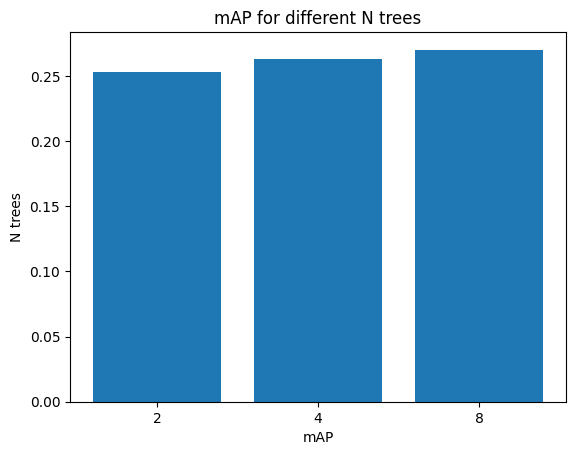

In [ ]:
mAP_scores_kdtree = [mAP_kdtree2, mAP_kdtree4, mAP_kdtree8]
labels_kdtree = ['2', '4', '8']

plot_chart(mAP_scores_kdtree, labels_kdtree, "mAP for different N trees", "mAP", "N trees")

Average Query Times - it increase with the number of trees

In [ ]:
import time
total_time_2_trees = 0
total_time_4_trees = 0
total_time_8_trees = 0
# Define the number of queries to run
num_queries = 5

# Loop through the queries
for i in range(num_queries):
    # Time how long the search takes
    start_time_2_trees = time.time() 
    results_2_trees = search_image(query_desc[i], index_2_trees, train_names)
    end_time_2_trees = time.time()

    start_time_4_trees = time.time()
    results_4_trees = search_image(query_desc[i], index_4_trees, train_names)
    end_time_4_trees = time.time()

    start_time_8_trees = time.time()
    results_8_trees = search_image(query_desc[i], index_8_trees, train_names)
    end_time_8_trees = time.time()

    # Add the time taken to the total
    total_time_2_trees += (end_time_2_trees - start_time_2_trees)
    total_time_4_trees += (end_time_4_trees - start_time_4_trees)
    total_time_8_trees += (end_time_8_trees - start_time_8_trees)

# Compute the average time taken
avg_time_2_trees = total_time_2_trees / num_queries
avg_time_4_trees = total_time_4_trees / num_queries
avg_time_8_trees = total_time_8_trees / num_queries

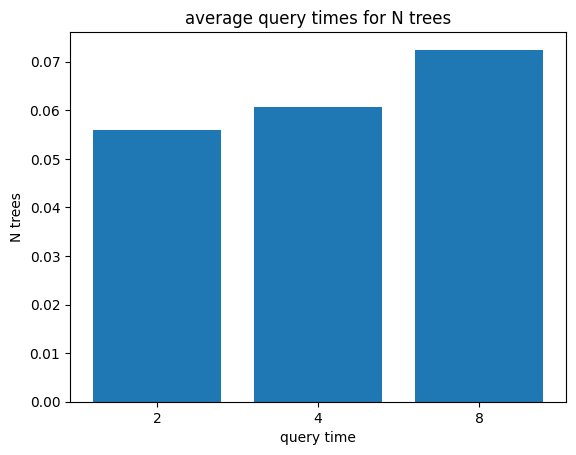

In [ ]:
avg_query_times_kdtree = [avg_time_2_trees, avg_time_4_trees, avg_time_8_trees]
labels_kdtree = ['2', '4', '8']

plot_chart(avg_query_times_kdtree, labels_kdtree, "average query times for N trees", "query time", "N trees")

Training Times

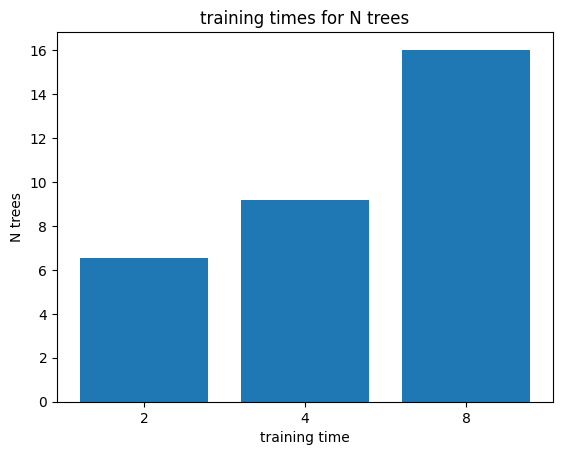

In [ ]:
plot_chart(train_time_kdtree, labels_kdtree, "training times for N trees", "training time", "N trees")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

### Locality Sensitive Hashing (LSH)
In this section, you will use LSH to index the database of images. The LSH implementation included in OpenCV uses **bit sampling** for **Hamming distance** as a hash function and, therefore, binary descriptors must be used. Hence, SIFT descriptors are not valid and we need to describe the images, but using, for instance, ORB.

In the following cell, write the code required to generate **roughly 1500 keypoints / descriptors** using ORB for each query / train image:

> **Useful links**: [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

In [ ]:
def generateAllDescriptorsAndKeypoints(query_images, train_images, no_keypoints=1500, no_descriptors=1500):
    """
    In this section, you will use LSH to index the database of images. The LSH implementation 
    included in OpenCV uses bit sampling for Hamming distance as a hash function and, therefore, 
    binary descriptors must be used. Hence, SIFT descriptors are not valid and we need to describe the images
    , but using, for instance, ORB.

    RETURN: 
    - query_kps_orb: list of keypoints for query images
    - query_desc_orb: list of descriptors for query images
    - train_kps_orb: list of keypoints for train images
    - train_desc_orb: list of descriptors for train images
    """ 
    
    orb = cv2.ORB_create(nfeatures=no_keypoints, nlevels=8, scoreType=cv2.ORB_FAST_SCORE)

    # Initialize keypoint and descriptor lists for query and train images
    query_kps_orb = []
    query_desc_orb = []
    train_kps_orb = []
    train_desc_orb = []

    # Generate keypoints and descriptors for query images
    for query_image in query_images:
      img = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
      kps, desc = orb.detectAndCompute(img, None)
      query_kps_orb.append(kps)
      query_desc_orb.append(desc)

    # Generate keypoints and descriptors for train images
    for train_image in train_images:
      img = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
      kps, desc = orb.detectAndCompute(img, None)
      train_kps_orb.append(kps)
      train_desc_orb.append(desc)

    return query_kps_orb, query_desc_orb, train_kps_orb, train_desc_orb

In [ ]:
[query_kps_orb, query_desc_orb, train_kps_orb, train_desc_orb] = generateAllDescriptorsAndKeypoints(query_imgs, train_imgs)

In [ ]:
# Show some data
print(len(query_kps_orb[0]))
print(query_desc_orb[0].shape)
print(query_desc_orb[0])

1563
(1563, 32)
[[ 45  45  17 ... 251  82 160]
 [ 13 220 255 ... 146  84 171]
 [203   4 103 ... 244 112 116]
 ...
 [211  13 119 ... 160 165 116]
 [224  98 157 ... 240 138  11]
 [162  43 172 ...  93  90 207]]


Next, write a function called `build_db_lsh` to build a **standard** (*no multi-probe*) LSH index from a set of images:

In [ ]:
def build_db_lsh(descs, tables = 6, hash_size = 12):
    """
    Index a set of images using LSH.    
    
    - descs: A list containing numpy arrays of size (~1500, 32). Each numpy array
        i corresponds to the ORB descriptors found at image i.
    - tables: Number of hash tables to create.
    - hash_size: Hash length in bits.
  
    RETURN: 
    - index: The trained LSH index.
    """  
    FLANN_INDEX_LSH = 6

    index_params= dict(algorithm = FLANN_INDEX_LSH,
                      table_number = tables,
                      key_size = hash_size,    
                      multi_probe_level = 0)
    search_params = dict(checks=50) 

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann.add(descs)
    flann.train()

    return flann

In [ ]:
# Simple example of DB construction
index = build_db_lsh(train_desc_orb[0:2])
print(len(index.getTrainDescriptors()))

2


**Q4**: In the following cell compute the resulting **mAP** of the system **using 6 tables and a hash size of 12**:

In [ ]:
# Fill this variable with the resulting mAP
mAP_lsh = 0.0

index = build_db_lsh(train_desc_orb)
results, mAP_lsh = compute_mAP(query_names, query_desc_orb, index, train_names, '../holidays/holidays_images.dat')

In [ ]:
print('mAP: %.5f' % mAP_lsh)

mAP: 0.20091


**Q5**: Are the results stable? Do you obtain always the same mAP? Why?

The results are stable with the same mAP being calculated with multiple attempts. The algorithms generate consistent and stable results across multiple runs because the nearest neighbors found for a particular query point will be the same each time the algorithm is run. 

In [ ]:
_, mAP_lsh_attempt1 = compute_mAP(query_names, query_desc_orb, index, train_names, '../holidays/holidays_images.dat')

_, mAP_lsh_attempt2 = compute_mAP(query_names, query_desc_orb, index, train_names, '../holidays/holidays_images.dat')

_, mAP_lsh_attempt3 = compute_mAP(query_names, query_desc_orb, index, train_names, '../holidays/holidays_images.dat')

different mAPs for the same query:  0.1990713761710488 0.1990713761710488 0.1990713761710488


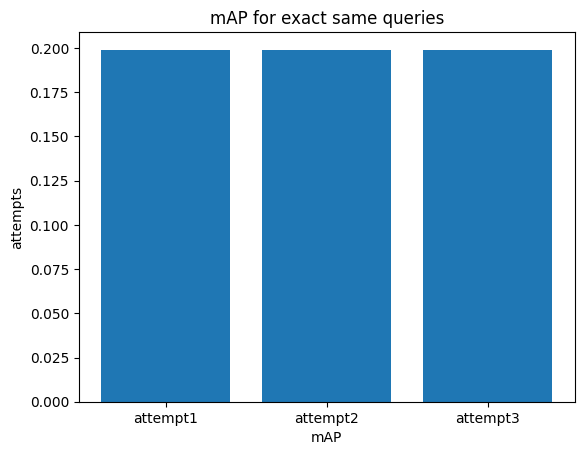

In [ ]:
print("different mAPs for the same query: ", mAP_lsh_attempt1, mAP_lsh_attempt2, mAP_lsh_attempt3)
values = [mAP_lsh_attempt1, mAP_lsh_attempt2, mAP_lsh_attempt3]
labels = ["attempt1", "attempt2", "attempt3"]
plot_chart(values, labels, "mAP for exact same queries", "mAP", "attempts")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q6**: Analyze the effect of changing the number of tables / hash size in terms of mAP and average response time. Some plots here can be useful to justify your answer.

The summary is seen here (plots to support shown below)

Response time effect:
- It's seen as the hash size increases the time taken to query goes down.
- It's seen as the number of tables increases the time to query goes up.


mAP effect:
- It's seen the increasing the hash size decreases the mAP.
- It's seen that increasing the tables size seems to slightly increase the mAP.


In [ ]:
import time
start_time = time.time()
index_table6_hash12 = build_db_lsh(train_desc_orb, tables = 6, hash_size =12)
train_time_table6_hash12 = time.time() - start_time

start_time = time.time()
index_table6_hash14 = build_db_lsh(train_desc_orb, tables = 6, hash_size =14)
train_time_table6_hash14 = time.time() - start_time

start_time = time.time()
index_table6_hash16 = build_db_lsh(train_desc_orb, tables = 6, hash_size =16)
train_time_table6_hash16 = time.time() - start_time

In [ ]:
start_time = time.time()
index_table8_hash12 = build_db_lsh(train_desc_orb, tables = 8, hash_size =12)
train_time_table8_hash12 = time.time() - start_time

start_time = time.time()
index_table10_hash12 = build_db_lsh(train_desc_orb, tables = 10, hash_size =12)
train_time_table10_hash12 = time.time() - start_time

mAP for changing hash number

In [ ]:
_, mAP_lsh_table6_hash12 = compute_mAP(query_names, query_desc_orb, index_table6_hash12, train_names, '../holidays/holidays_images.dat')

In [ ]:
_, mAP_lsh_table6_hash14 = compute_mAP(query_names, query_desc_orb, index_table6_hash14, train_names, '../holidays/holidays_images.dat')

In [ ]:
_, mAP_lsh_table6_hash16 = compute_mAP(query_names, query_desc_orb, index_table6_hash16, train_names, '../holidays/holidays_images.dat')

mAP for changing table number

In [ ]:
_, mAP_lsh_table8_hash12 = compute_mAP(query_names, query_desc_orb, index_table8_hash12, train_names, '../holidays/holidays_images.dat')

In [ ]:
_, mAP_lsh_table10_hash12 = compute_mAP(query_names, query_desc_orb, index_table10_hash12, train_names, '../holidays/holidays_images.dat')

In [ ]:
# Data for the bar chart
mAP_scores_lsh_changing_tables = [mAP_lsh_table6_hash12, mAP_lsh_table8_hash12, mAP_lsh_table10_hash12]
mAP_scores_lsh_changing_hash = [mAP_lsh_table6_hash12, mAP_lsh_table6_hash14, mAP_lsh_table6_hash16]
mAP_scores_lsh_total = [mAP_lsh_table6_hash12, mAP_lsh_table8_hash12, mAP_lsh_table10_hash12, mAP_lsh_table6_hash14, mAP_lsh_table6_hash16]

labels_lsh_changing_tables = ['table6_hash12', 'table8_hash12','table10_hash12']
labels_lsh_changing_hash = ['table6_hash12', 'table6_hash14','table6_hash16']
labels_lsh = ['table6_hash12', 'table8_hash12','table10_hash12','table6_hash14','table6_hash16']

training_time_lsh_tables = [train_time_table6_hash12, train_time_table8_hash12, train_time_table10_hash12]
training_time_lsh_hash= [train_time_table6_hash12, train_time_table6_hash14, train_time_table6_hash16]
training_time_lsh = [train_time_table6_hash12, train_time_table8_hash12, train_time_table10_hash12, train_time_table6_hash14, train_time_table6_hash16]

In [ ]:
print("mAP_scores_lsh_total", mAP_scores_lsh_total)
print("training_time_lsh", training_time_lsh)

mAP_scores_lsh_total [0.19304631122335333, 0.20667118016017863, 0.2287758162883553, 0.1733602955960106, 0.14263099239931917]
training_time_lsh [0.7333700656890869, 1.357966423034668, 1.4565033912658691, 1.2837955951690674, 2.171107530593872]


Average response time calculation

In [ ]:
total_time_table6_hash12 = 0
total_time_table6_hash14 = 0
total_time_table6_hash16 = 0
total_time_table8_hash12 = 0
total_time_table10_hash12 = 0
# Define the number of queries to run
num_queries = 5

# Loop through the queries
for i in range(num_queries):
    # Time how long the search take
    start_time_table6_hash12 = time.time() 
    results_table6_hash12 = search_image(query_desc_orb[i], index_table6_hash12, train_names)
    end_time_table6_hash12 = time.time()
  
    start_time_table6_hash14 = time.time()
    results_table6_hash14 = search_image(query_desc_orb[i], index_table6_hash14, train_names)
    end_time_table6_hash14 = time.time()

    start_time_table6_hash16 = time.time()
    results_table6_hash16 = search_image(query_desc_orb[i], index_table6_hash16, train_names)
    end_time_table6_hash16 = time.time()

    start_time_table8_hash12 = time.time()
    results_table8_hash12 = search_image(query_desc_orb[i], index_table8_hash12, train_names)
    end_time_table8_hash12 = time.time()

    start_time_table10_hash12 = time.time()
    results_table10_hash12 = search_image(query_desc_orb[i], index_table10_hash12, train_names)
    end_time_table10_hash12 = time.time()


    total_time_table6_hash12 += (end_time_table6_hash12 - start_time_table6_hash12)
    total_time_table6_hash14 += (end_time_table6_hash14 - start_time_table6_hash14)
    total_time_table6_hash16 += (end_time_table6_hash16 - start_time_table6_hash16)
    total_time_table8_hash12 += (end_time_table8_hash12 - start_time_table8_hash12)
    total_time_table10_hash12 += (end_time_table10_hash12 - start_time_table10_hash12)

# Compute the average time taken
avg_time_table6_hash12 = total_time_table6_hash12 / num_queries
avg_time_table6_hash14 = total_time_table6_hash14 / num_queries
avg_time_table6_hash16 = total_time_table6_hash16 / num_queries
avg_time_table8_hash12 = total_time_table8_hash12 / num_queries
avg_time_table10_hash12 = total_time_table10_hash12 / num_queries

In [ ]:
avg_query_time_lsh_hash = [avg_time_table6_hash12, avg_time_table6_hash14, avg_time_table6_hash16]
avg_query_time_lsh_table = [avg_time_table6_hash12, avg_time_table8_hash12, avg_time_table10_hash12]
avg_query_time_lsh = [avg_time_table6_hash12, avg_time_table6_hash14, avg_time_table6_hash16, avg_time_table8_hash12, avg_time_table10_hash12]
print("avg_query_time_lsh: ", avg_query_time_lsh)

avg_query_time_lsh:  [1.631845235824585, 0.537563419342041, 0.22275028228759766, 1.8914031028747558, 2.7919068813323973]


Change response time when changing hash size. It's seen as the hash size increases the time taken to query goes down.



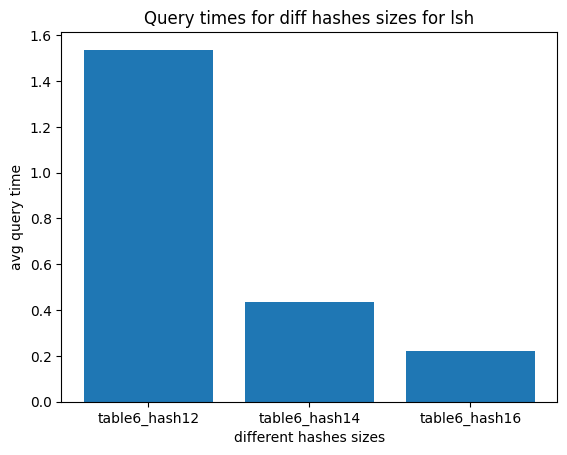

In [ ]:
plot_chart(avg_query_time_lsh_hash, labels_lsh_changing_hash, "Query times for diff hashes sizes for lsh", "different hashes sizes", "avg query time")

Changing response time when changing table size. It's seen as the number of tables increases the time to query goes up.

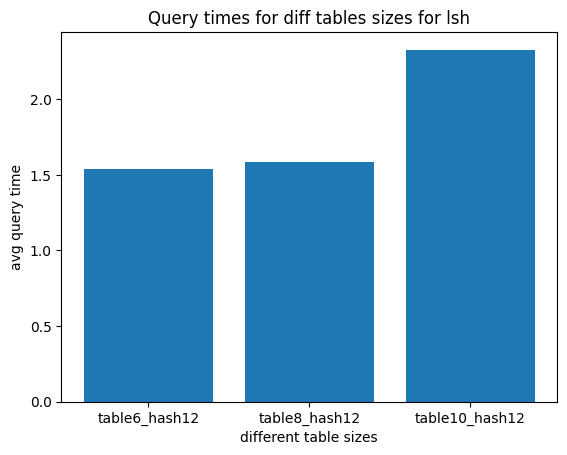

In [ ]:
plot_chart(avg_query_time_lsh_table, labels_lsh_changing_tables, "Query times for diff tables sizes for lsh", "different table sizes", "avg query time")

mAP for different hash sizes. It's seen the increasing the hash size decreases the mAP.



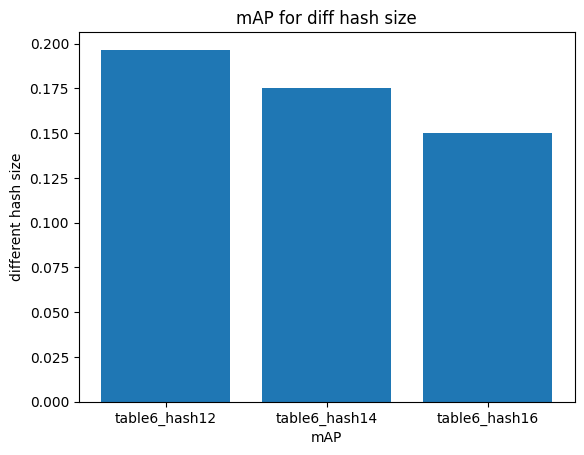

In [ ]:
plot_chart(mAP_scores_lsh_changing_hash, labels_lsh_changing_hash, "mAP for diff hash size", "mAP", "different hash size")

mAP for different table sizes. It's seen that increasing the tables size seems to slightly increase the mAP.

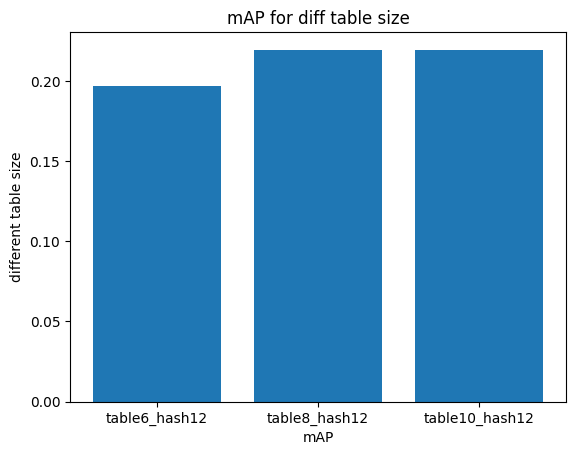

In [ ]:
plot_chart(mAP_scores_lsh_changing_tables, labels_lsh_changing_tables, "mAP for diff table size", "mAP", "different table size")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q7:** Despite the different descriptors used, compare the performance of the randomized k-d trees and LSH approaches from different points of view (accuracy, training times, querying times, ...). Some plots can be useful here to justify your answer.

Comparison

mAP:
- the kdtree does better than lsh for mAP

training time:
- the training time for kdtree is longer than lsh

avg query time:
- lsh avg query time is greater than kdtree


Comparison via mAP

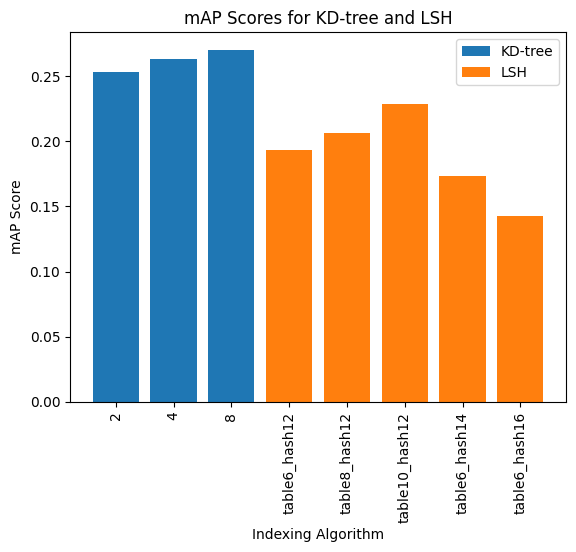

In [ ]:
# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(labels_kdtree, mAP_scores_kdtree, label='KD-tree')
ax.bar(labels_lsh, mAP_scores_lsh_total, label='LSH')

# Set the chart title, axis labels, and legend
ax.set_title('mAP Scores for KD-tree and LSH')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('mAP Score')
ax.legend()

Comparison via Train times

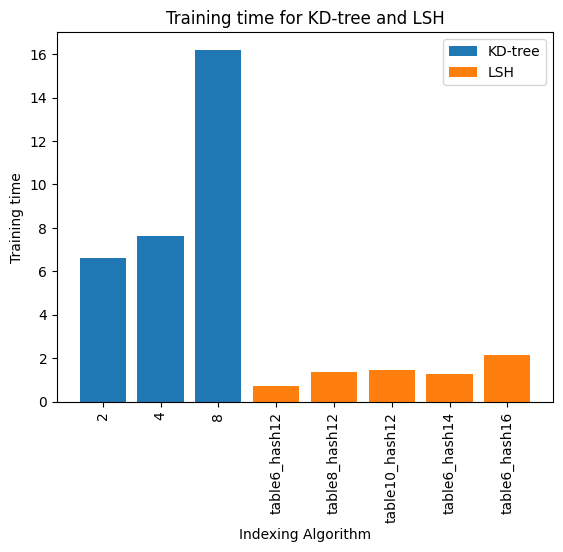

In [ ]:
# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(labels_kdtree, train_time_kdtree, label='KD-tree')
ax.bar(labels_lsh, training_time_lsh, label='LSH')

# Set the chart title, axis labels, and legend
ax.set_title('Training time for KD-tree and LSH')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('Training time')
ax.legend()

Comparison via Query times

In [ ]:
avg_query_time_lsh_total = [avg_time_table6_hash12, avg_time_table6_hash14, avg_time_table6_hash16, avg_time_table8_hash12, avg_time_table10_hash12]

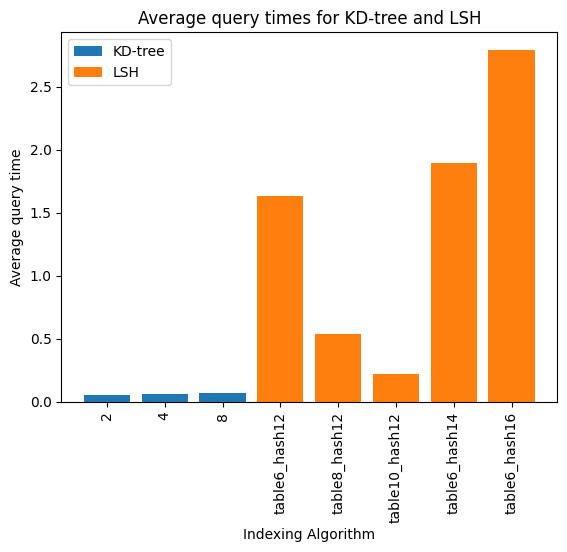

In [ ]:
# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(labels_kdtree, avg_query_times_kdtree, label='KD-tree')
ax.bar(labels_lsh, avg_query_time_lsh_total, label='LSH')

# Set the chart title, axis labels, and legend
ax.set_title('Average query times for KD-tree and LSH')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('Average query time')
ax.legend()

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Bag-of-Words
In this section, you will implement the Bag-of-Words (BoW) model for image retrieval. Additionally, you will also implement the TF-IDF scoring scheme.

### Download visual dictionaries
To use a BoW model, first we need a visual vocabulary. The authors of the INRIA Holidays dataset provide some visual vocabularies, trained using a clustering method (e.g. $k$-means) in a different dataset (Flickr60K).

First, download these vocabularies from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/EY1G011OvfJOnwqWQQzmHmgBkXhLHBaK00wdizsUT252dw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

A folder named `clust` is now available in your workspace, containing visual vocabularies of 100, 200, 500, 1K, 2K, 5K, 10K, 20K, 50K, 100K and 200K visual words. Again, these are binary files, and therefore we provide you with functions to load and index them:

In [ ]:
voc = rd.load_visual_vocab("../clust/clust_flickr60_k200.fvecs", ntrees=4)

With this function, the corresponding vocabulary is read. Additionally, a FLANN index structure based on kd-trees is built and returned using the centroids. This is to allow a fast access when searching for the closest visual words in the vocabulary. More precisely, in this example, 4 trees are constructed using the vocabulary of 200 centroids. Now, given a query descriptor(s), you can use `match` or `knnMatch` methods as usual to search for the closest (approximate) visual word(s) in the vocabulary.

### BoW and Inverted File
Now, write a class called `BoW` to manage the indexing procedure. This class should make use, in addition to the visual vocabulary, an inverted file to compute similarity scores between images. Apart from the class constructor, write three methods: `build_db`, `search_image` and `compute_mAP`:

In [25]:
class BoW:
    """
    Class to implement the BoW model + Inverted File.
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently.
    
        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        for i in range(len(img_names)):
            img_desc = img_descs[i]
            visual_words = self.vocab.knnMatch(img_desc, k=1)
            bow_hist = np.zeros(self.nwords)

            for vw in visual_words:
                word_id = vw[0].trainIdx
                bow_hist[word_id] += 1

            for word_id, word_count in enumerate(bow_hist):
                if word_count > 0:
                    self.inv_list[word_id][img_names[i]] = word_count

    def search_image(self, descs):
        """
        Search an image in the index.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """

        visual_words = self.vocab.knnMatch(descs, k=1)
        bow_hist = np.zeros(self.nwords)

        for vw in visual_words:
            word_id = vw[0].trainIdx
            bow_hist[word_id] += 1

        scores = {}
        for word_id, word_count in enumerate(bow_hist):
            if word_count == 0:
                continue
            for image_id, inv_count in self.inv_list[word_id].items():
                if image_id not in scores:
                    scores[image_id] = 0
                scores[image_id] += word_count * inv_count

        sorted_images = sorted(scores, key=scores.get, reverse=True)
        return sorted_images
      
    def compute_mAP(self, query_names, query_descs, gt_file):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0
        for qname, qdesc in zip(query_names, query_desc):
            # Search for similar images
            results = self.search_image(qdesc)
            total_results[qname] = results
        
        m_ap = ev.compute_mAP(total_results, gt_file)
        return total_results, m_ap

In [ ]:
# Example of use
index = BoW('../clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [ ]:
res = index.search_image(query_desc[0])
print(res)

['100001.jpg', '100002.jpg']


In [ ]:
results, mAP = index.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')
print(results)
print(mAP)

{'100000.jpg': ['100001.jpg', '100002.jpg'], '100100.jpg': ['100001.jpg', '100002.jpg'], '100200.jpg': ['100001.jpg', '100002.jpg'], '100300.jpg': ['100001.jpg', '100002.jpg'], '100400.jpg': ['100001.jpg', '100002.jpg'], '100500.jpg': ['100001.jpg', '100002.jpg'], '100600.jpg': ['100001.jpg', '100002.jpg'], '100700.jpg': ['100001.jpg', '100002.jpg'], '100800.jpg': ['100001.jpg', '100002.jpg'], '100900.jpg': ['100001.jpg', '100002.jpg'], '101000.jpg': ['100001.jpg', '100002.jpg'], '101100.jpg': ['100001.jpg', '100002.jpg'], '101200.jpg': ['100001.jpg', '100002.jpg'], '101300.jpg': ['100001.jpg', '100002.jpg'], '101400.jpg': ['100001.jpg', '100002.jpg'], '101500.jpg': ['100001.jpg', '100002.jpg'], '101600.jpg': ['100001.jpg', '100002.jpg'], '101700.jpg': ['100001.jpg', '100002.jpg'], '101800.jpg': ['100001.jpg', '100002.jpg'], '101900.jpg': ['100001.jpg', '100002.jpg'], '102000.jpg': ['100001.jpg', '100002.jpg'], '102100.jpg': ['100001.jpg', '100002.jpg'], '102200.jpg': ['100001.jpg', '1

**Q8**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [26]:
import time

mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

start_time = time.time()
index_200 = BoW('clust/clust_flickr60_k200.fvecs')
index_200.build_db(train_names, train_desc)
train_time_200 = time.time() - start_time
print("train_time_200 %s seconds: ", train_time_200)
results_200, mAP_200 = index_200.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

start_time = time.time()
index_2K = BoW('clust/clust_flickr60_k2000.fvecs')
index_2K.build_db(train_names, train_desc)
train_time_2K = time.time() - start_time
print("train_time_2K %s seconds: ", train_time_2K)
results_2K, mAP_2K = index_2K.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

start_time = time.time()
index_20K = BoW('clust/clust_flickr60_k20000.fvecs')
index_20K.build_db(train_names, train_desc)
train_time_20K = time.time() - start_time
print("train_time_20K %s seconds: ", train_time_20K)
results_20K, mAP_20K = index_20K.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

start_time = time.time()
index_200K = BoW('clust/clust_flickr60_k200000.fvecs')
index_200K.build_db(train_names, train_desc)
train_time_200K = time.time() - start_time
print("train_time_200K %s seconds: ", train_time_200K)
results_200K, mAP_200K = index_200K.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

train_time_200 %s seconds:  11.292835712432861
train_time_2K %s seconds:  13.842697858810425
train_time_20K %s seconds:  27.849180221557617
train_time_200K %s seconds:  105.3392424583435


In [ ]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

mAP 200: 0.05825
mAP 2K: 0.15388
mAP 20K: 0.31004
mAP 200K: 0.46842


**Q9**: Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

In [27]:
mAP_bow = [mAP_200, mAP_2K, mAP_20K, mAP_200K]
labels_bow = ["mAP_200", "mAP_2K", "mAP_20K", "mAP_200K"]

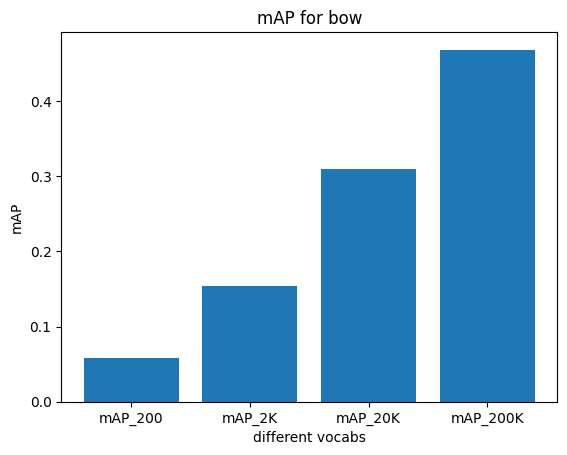

In [ ]:
plot_chart(mAP_bow, labels_bow, "mAP for bow", "different vocabs", "mAP")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q10**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

Analysis:
- As the vocab increases the train time increases
- For Avg Query Times increasing the vocabulary size has a mixed effect on query times. While some queries are faster with the increased vocabulary (0.0476s and 0.0501s), others are slower (0.0704s and 0.0983s). This suggests that the impact of vocabulary size on query time may depend on the specific input data and query being used.

In [28]:
# Initialize a variable to store the total time taken
total_time_200 = 0
total_time_2K = 0
total_time_20K = 0
total_time_200K = 0
# Define the number of queries to run
num_queries = 10

# Loop through the queries
for i in range(num_queries):
    # Time how long the search takes
    start_time_200 = time.time()
    results_200 = index_200.search_image(query_desc[i])
    end_time_200 = time.time()

    start_time_2K = time.time()
    results_2K = index_2K.search_image(query_desc[i])
    end_time_2K = time.time()

    start_time_20K = time.time()
    results_20K = index_20K.search_image(query_desc[i])
    end_time_20K = time.time()

    start_time_200K = time.time()
    results_200K = index_200K.search_image(query_desc[i])
    end_time_200K = time.time()

    # Add the time taken to the total
    total_time_200 += (end_time_200 - start_time_200)
    total_time_2K += (end_time_2K - start_time_2K)
    total_time_20K += (end_time_20K - start_time_20K)
    total_time_200K += (end_time_200K - start_time_200K)

# Compute the average time taken
avg_time_200 = total_time_200 / num_queries
avg_time_2K = total_time_2K / num_queries
avg_time_20K = total_time_20K / num_queries
avg_time_200K = total_time_200K / num_queries

print("avg_time_200: {:.3f} seconds".format(avg_time_200))
print("avg_time_2K: {:.3f} seconds".format(avg_time_2K))
print("avg_time_20K: {:.3f} seconds".format(avg_time_20K))
print("avg_time_200K: {:.3f} seconds".format(avg_time_200K))

avg_time_200: 0.052 seconds
avg_time_2K: 0.069 seconds
avg_time_20K: 0.051 seconds
avg_time_200K: 0.100 seconds


Train times:
As the vocab increases the train time increases

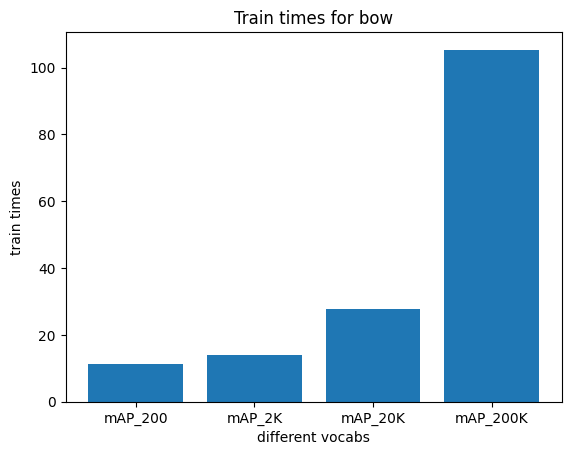

In [31]:
training_time_bow = [train_time_200, train_time_2K, train_time_20K, train_time_200K]
plot_chart(training_time_bow, labels_bow, "Train times for bow", "different vocabs", "train times")

Avg Query Times:
The results show that increasing the vocabulary size has a mixed effect on query times. While some queries are faster with the increased vocabulary (0.0476s and 0.0501s), others are slower (0.0704s and 0.0983s). This suggests that the impact of vocabulary size on query time may depend on the specific input data and query being used.

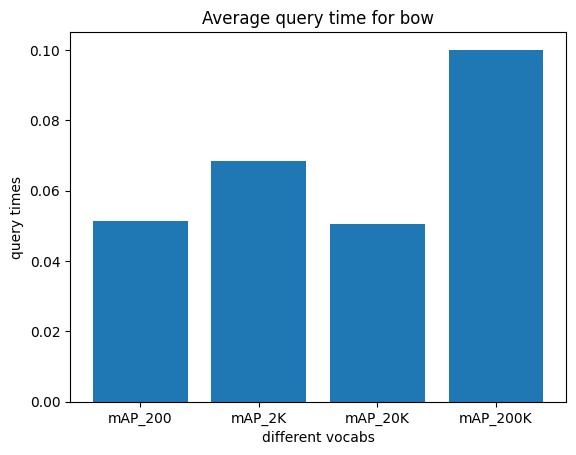

In [32]:
avg_query_times_bow = [avg_time_200, avg_time_2K, avg_time_20K, avg_time_200K]
plot_chart(avg_query_times_bow, labels_bow, "Average query time for bow", "different vocabs", "query times")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q11**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Yes, the results obtained with bag-of-words (BoW) depend on the set of images used to generate the vocabulary. 

To improve the retrieval performance with BoW, there are several strategies that can be employed:

1) Increase the size of the vocabulary: Using a larger vocabulary with more visual words can increase the discriminative power of the representation, allowing for more accurate retrieval results. 

2) Use a more diverse set of images to generate the vocabulary: Using a larger and more diverse set of training images can improve the quality of the visual vocabulary, allowing for better representation of the visual features in the query images.

3) Use more advanced techniques, such as deep learning-based methods, to improve the representation of the images and capture more complex visual relationships. These techniques can further improve the retrieval performance beyond what can be achieved with traditional BoW methods.

### TF-IDF
As a final task of this assignment, let's implement the TF-IDF scoring scheme. Modify the `BoW` class you wrote before to include the TF-IDF weighting scheme:

In [10]:
class BoW_TFIDF:
    """
    Class to implement the BoW model + Inverted File.
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}
        self.tfidf = {}

    def build_db(self, img_names, img_descs):
      """
      Build an index from a set of images. Essentially, for each image, you should
      search its descriptors in the index in order to find the closest visual words
      and fill the inverted file structure consequently.

      - img_names: An ordered list with the names of the train images
      - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
        to the descriptors found at image i
      """
      for i, img_desc in enumerate(img_descs):
            visual_words = self.vocab.knnMatch(img_desc, k=1)
            bow_hist = np.zeros(self.nwords)

            for vw in visual_words:
                word_id = vw[0].trainIdx
                bow_hist[word_id] += 1

            # Normalize the bow_hist vector
            norm = np.linalg.norm(bow_hist)
            if norm > 0:
                bow_hist = bow_hist / norm

            for word_id, word_count in enumerate(bow_hist):
                if word_count > 0:
                    self.inv_list[word_id][img_names[i]] = word_count

        # Compute the inverse document frequency (IDF) for each word
        # IDF(word_id=1) =  log(number of images/number of images containing the desc word_id=1) 
      n_docs = np.array([len(self.inv_list[word_id]) for word_id in range(self.nwords)])
      self.idf = np.log10((len(img_names) + 1) / (n_docs + 1)) + 1

      self.tfidf = {}
      for i, img_desc in enumerate(img_descs):
          bow_hist = np.zeros(self.nwords)
          visual_words = self.vocab.knnMatch(img_desc, k=1)

          for vw in visual_words:
              word_id = vw[0].trainIdx
              bow_hist[word_id] += 1

          # Compute the TF-IDF for each word in the image
          # TF-IDF(word_id=1, image_names[0]) = TF(word_id=1, image_names[0]) * IDF(word_id=1)
          tfidf_hist = bow_hist * self.idf

          # Normalize the tfidf_hist vector
          norm = np.linalg.norm(tfidf_hist)
          if norm > 0:
              tfidf_hist = tfidf_hist / norm

          # Add the TF-IDF histogram to the self.tfidf dictionary
          self.tfidf[img_names[i]] = tfidf_hist


    def search_image(self, descs):
        """
        Search an image in the index.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """

        # Compute the bag of visual words for the query image
        visual_words = self.vocab.knnMatch(descs, k=1)
        bow_hist = np.zeros(self.nwords)
        for vw in visual_words:
            word_id = vw[0].trainIdx
            bow_hist[word_id] += 1

        # Compute the TF-IDF weighted bag of visual words for the query image
        tfidf_hist = np.zeros(self.nwords)
        for word_id, word_count in enumerate(bow_hist):
            if word_count > 0:
                tfidf_hist[word_id] = word_count * self.idf[word_id]

        # Normalize the tfidf_hist vector
        norm = np.linalg.norm(tfidf_hist)
        if norm > 0:
            tfidf_hist = tfidf_hist / norm

        # Compute the cosine similarity scores between the query image and each image in the database
        scores = {}
        for image_id, image_tfidf_hist in self.tfidf.items():
            score = np.dot(tfidf_hist, image_tfidf_hist)
            scores[image_id] = score

        # Sort the images in descending order by their similarity scores
        sorted_images = sorted(scores, key=scores.get, reverse=True)

        return sorted_images
      
    def compute_mAP(self, query_names, query_descs, gt_file):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0
        for qname, qdesc in zip(query_names, query_descs):
            # Search for similar images
            results = self.search_image(qdesc)
            total_results[qname] = results

        m_ap = ev.compute_mAP(total_results, gt_file)
        return total_results, m_ap

In [11]:
# Example of use
index = BoW_TFIDF('../clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [12]:
res = index.search_image(query_desc[0])
print(res)

['100001.jpg', '100002.jpg']


**Q12**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [14]:
import time

mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

start_time = time.time()
index_200 = BoW_TFIDF('clust/clust_flickr60_k200.fvecs')
index_200.build_db(train_names, train_desc)
train_time_200 = time.time() - start_time
results_200, mAP_200 = index_200.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

start_time = time.time()
index_2K = BoW_TFIDF('clust/clust_flickr60_k2000.fvecs')
index_2K.build_db(train_names, train_desc)
train_time_2K = time.time() - start_time
results_2K, mAP_2K = index_2K.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

start_time = time.time()
index_20K = BoW_TFIDF('clust/clust_flickr60_k20000.fvecs')
index_20K.build_db(train_names, train_desc)
train_time_20K = time.time() - start_time
results_20K, mAP_20K = index_20K.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

start_time = time.time()
index_200K = BoW_TFIDF('clust/clust_flickr60_k200000.fvecs')
index_200K.build_db(train_names, train_desc)
train_time_200K = time.time() - start_time
results_200K, mAP_200K = index_200K.compute_mAP(query_names, query_desc, '../holidays/holidays_images.dat')

In [15]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

mAP 200: 0.41180
mAP 2K: 0.47421
mAP 20K: 0.49072
mAP 200K: 0.52884


**Q13:** Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

For bow-tfidf increasing the vocab size causes the mAP to increase. 

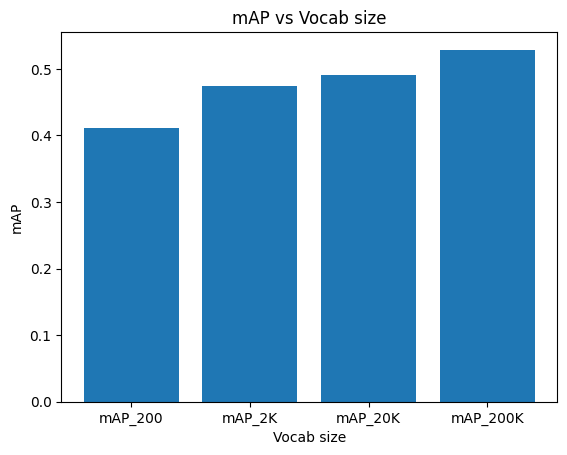

In [18]:
# Data for the bar chart
map_scores_bow_TFIDF = [mAP_200, mAP_2K, mAP_20K, mAP_200K]
labels = ['mAP_200', 'mAP_2K', 'mAP_20K', 'mAP_200K']

plot_chart(map_scores_bow_TFIDF, labels, "mAP vs Vocab size", "Vocab size", "mAP")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q14**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

In [19]:
print('training time 200: %.5f' % train_time_200)
print('training time 2K: %.5f' % train_time_2K)
print('training time 20K: %.5f' % train_time_20K)
print('training time 200K: %.5f' % train_time_200K)

training time 200: 29.23446
training time 2K: 27.48345
training time 20K: 78.50803
training time 200K: 214.32159


Training time bow-TDIF - the higher the vocab the longer the training time

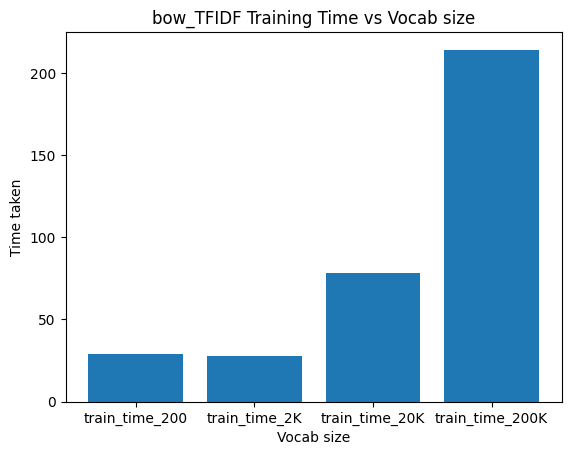

In [20]:
# Data for the bar chart
train_times_bow_TFIDF = [train_time_200, train_time_2K, train_time_20K, train_time_200K]
labels = ['train_time_200', 'train_time_2K', 'train_time_20K', 'train_time_200K']

plot_chart(train_times_bow_TFIDF, labels, "bow_TFIDF Training Time vs Vocab size", "Vocab size", "Time taken")

In [21]:
# Initialize a variable to store the total time taken
total_time_200 = 0
total_time_2K = 0
total_time_20K = 0
total_time_200K = 0
# Define the number of queries to run
num_queries = 10

# Loop through the queries
for i in range(num_queries):
    # Time how long the search takes
    start_time_200 = time.time()
    results_200 = index_200.search_image(query_desc[i])
    end_time_200 = time.time()

    start_time_2K = time.time()
    results_2K = index_2K.search_image(query_desc[i])
    end_time_2K = time.time()

    start_time_20K = time.time()
    results_20K = index_20K.search_image(query_desc[i])
    end_time_20K = time.time()

    start_time_200K = time.time()
    results_200K = index_200K.search_image(query_desc[i])
    end_time_200K = time.time()

    # Add the time taken to the total
    total_time_200 += (end_time_200 - start_time_200)
    total_time_2K += (end_time_2K - start_time_2K)
    total_time_20K += (end_time_20K - start_time_20K)
    total_time_200K += (end_time_200K - start_time_200K)

# Compute the average time taken
avg_time_200 = total_time_200 / num_queries
avg_time_2K = total_time_2K / num_queries
avg_time_20K = total_time_20K / num_queries
avg_time_200K = total_time_200K / num_queries

print("avg_time_200: {:.3f} seconds".format(avg_time_200))
print("avg_time_2K: {:.3f} seconds".format(avg_time_2K))
print("avg_time_20K: {:.3f} seconds".format(avg_time_20K))
print("avg_time_200K: {:.3f} seconds".format(avg_time_200K))

avg_time_200: 0.021 seconds
avg_time_2K: 0.026 seconds
avg_time_20K: 0.062 seconds
avg_time_200K: 0.354 seconds


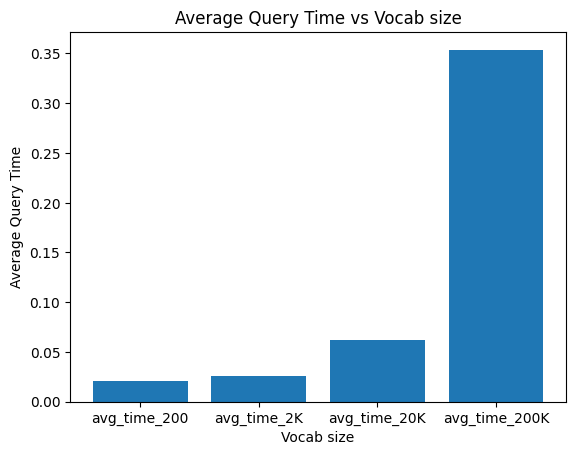

In [22]:
# Data for the bar chart
avg_time_bow_TFIDF = [avg_time_200, avg_time_2K, avg_time_20K, avg_time_200K]
labels = ['avg_time_200', 'avg_time_2K', 'avg_time_20K', 'avg_time_200K']

plot_chart(avg_time_bow_TFIDF, labels, "Average Query Time vs Vocab size", "Vocab size", "Average Query Time")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q15**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Yes, the results obtained with bag-of-words (BoW) depend on the set of images used to generate the vocabulary. 

To improve the retrieval performance with BoW, there are several strategies that can be employed:

1) Increase the size of the vocabulary: Using a larger vocabulary with more visual words can increase the discriminative power of the representation, allowing for more accurate retrieval results. 

2) Use a more diverse set of images to generate the vocabulary: Using a larger and more diverse set of training images can improve the quality of the visual vocabulary, allowing for better representation of the visual features in the query images.

3) Use more advanced techniques, such as deep learning-based methods, to improve the representation of the images and capture more complex visual relationships. These techniques can further improve the retrieval performance beyond what can be achieved with traditional BoW methods.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q16:** How does TF-IDF affect the performance? Better or worse? Does this make sense?

In [23]:
x_labels = ['BoW_200', 'BoW_2K', 'BoW_20K', 'BoW_200K', 'BoW_TFIDF_200', 'BoW_TFIDF_2K', 'BoW_TFIDF_20K', 'BoW_TFIDF_200K']

mAP for bow and bow_TFIDF

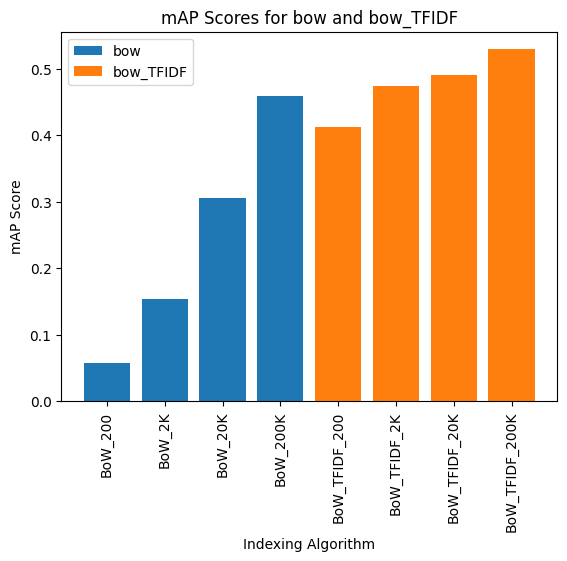

In [29]:
# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(x_labels[:4], mAP_bow, label='bow')
ax.bar(x_labels[4:], map_scores_bow_TFIDF, label='bow_TFIDF')

# Set the chart title, axis labels, and legend
ax.set_title('mAP Scores for bow and bow_TFIDF')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('mAP Score')
ax.legend()

Training time for bow and bow_TFIDF

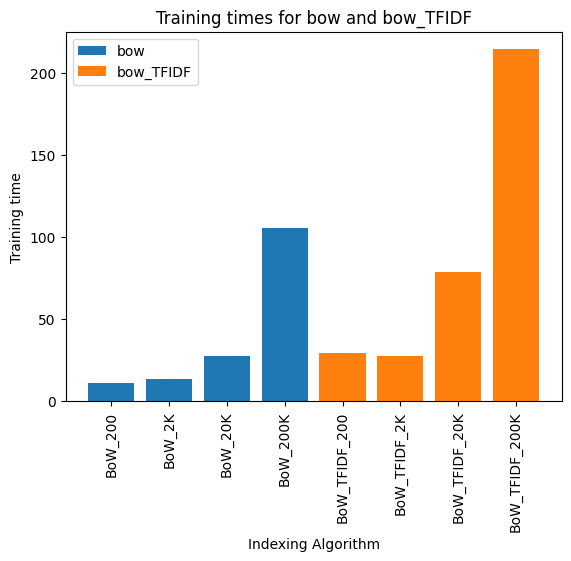

In [33]:
# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(x_labels[:4], training_time_bow, label='bow')
ax.bar(x_labels[4:], train_times_bow_TFIDF, label='bow_TFIDF')

# Set the chart title, axis labels, and legend
ax.set_title('Training times for bow and bow_TFIDF')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('Training time')
ax.legend()

Avg query response times

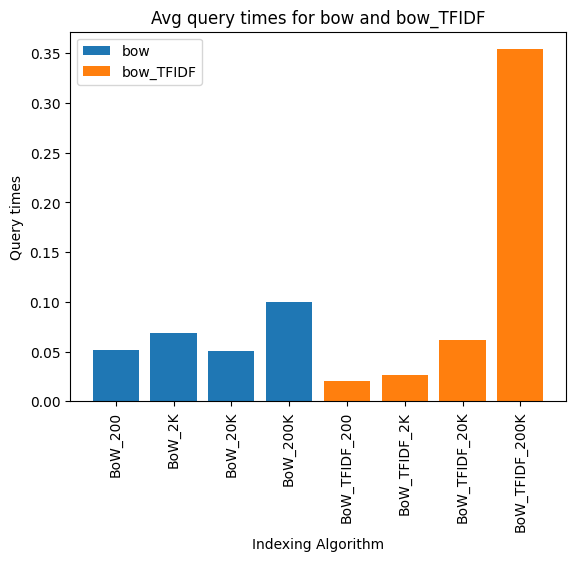

In [34]:
# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(x_labels[:4], avg_query_times_bow, label='bow')
ax.bar(x_labels[4:], avg_time_bow_TFIDF, label='bow_TFIDF')

# Set the chart title, axis labels, and legend
ax.set_title('Avg query times for bow and bow_TFIDF')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('Query times')
ax.legend()

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [ ]:
zip_filename = DNI + '_A2.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A2/Image_Indexing.ipynb'
zf.write('Image_Indexing.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A2.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://uibdigital.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands